# 1d3v electron hybrid code for R/L-waves with stationary ions and dipole background field

## 1. The model
The electron hybrid model for cold electrons with linearized fluid equations and hot kinetic electrons (Vlasov equation) reads

\begin{align}
&\frac{\partial\tilde{\mathbf{j}}_\mathrm{c}}{\partial t}=\epsilon_0\Omega_\mathrm{pe}^2\tilde{\mathbf{E}}+\tilde{\mathbf{j}}_\mathrm{c}\times\mathbf{\Omega}_\mathrm{ce}(\mathbf{x}),\\
&\frac{\partial f_\mathrm{h}}{\partial t}+\mathbf{v}\cdot\nabla f_\mathrm{h}+\frac{q_\mathrm{e}}{m_\mathrm{e}}(\mathbf{E}+\mathbf{v}\times\mathbf{B})\cdot\nabla_\mathbf{v}f_\mathrm{h}=0,\\
&\frac{\partial \tilde{\mathbf{B}}}{\partial t}=-\nabla\times\tilde{\mathbf{E}},\\
&\frac{1}{c^2}\frac{\partial \tilde{\mathbf{E}}}{\partial t}=\nabla\times\tilde{\mathbf{B}}-\mu_0\tilde{\mathbf{j}}_\mathrm{c}-\mu_0q_\mathrm{e}\int\mathbf{v}\tilde{f}_\mathrm{h}\,\mathrm{d}^3\mathbf{v},
\end{align}

where $\mathbf{\Omega}_\mathrm{ce}(\mathbf{x})=q_\mathrm{e}\mathbf{B}_0(\mathbf{x})/m_\mathrm{e}$ is the oriented electron cyclotron frequency corresponding to the background field $\mathbf{B}_0=\mathbf{B}_0(\mathbf{x})$ and $\Omega_{\mathrm{pe}}^2=n_{\mathrm{c}0}e^2/\epsilon_0m_\mathrm{e}$ the plasma frequency of the cold electrons. Here, only wave propagation parallel to the background magnetic field $\mathbf{B}_0=\mathbf{B}_0(\mathbf{x})$ is considered, i.e. $\textbf{k}=k\textbf{e}_z$. Therefore the nabla operator is simply $\nabla=\textbf{e}_z\partial_z$. The background magnetic field is a parabolically shaped.

We use homogeneous Dirichlet boundary conditions with a masking function for all quantities.

In [4]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

import psydac.core.interface as inter

import time

import utilitis_opt as utils_opt
import utilitis_pic


#====================================================================================
#  calling epyccel
#====================================================================================
from pyccel.epyccel import epyccel
utils_pic_fast = epyccel(utilitis_pic)
print('pyccelization of pic functions done!')
#====================================================================================



#===== saving data? (save = 1: yes, save = 0: no). If yes, name directory ===========
save = 1
title = 'test.txt' 
#====================================================================================



#===== save only every saving_step-th time step =====================================
saving_step = 2
#====================================================================================



#===== physical parameters ==========================================================
eps0 = 1.0                         # vacuum permittivity
mu0 = 1.0                          # vacuum permeability
c = 1.0                            # speed of light
qe = -1.0                          # electron charge
me = 1.0                           # electron mass
B0z = 1.0                          # minimum of background magnetic field in z-direction
wce = qe*B0z/me                    # electron cyclotron frequency
wpe = 5*np.abs(wce)                # cold electron plasma frequency
nuh = 6e-3                         # ratio of cold/hot electron densities (nh/nc)
nh = nuh*wpe**2                    # hot electron density
wpar = 0.2*c                       # parallel thermal velocity of energetic particles
wperp = 0.53*c                     # perpendicular thermal velocity of energetic particles

xi = 8.62e-5                       # inhomogeneity factor of background magnetic field

bcs_d = 1                          # damping of wave fields at boundaries? (1: yes, 0: no)
bcs_g = 1                          # field line dependence of initial distribution function? (1: yes, 0: no)
#====================================================================================



#===== initial conditions ===========================================================
k = 2.                             # wavenumber of initial wave field perturbations
amp = 1e-4                         # amplitude of initial wave field perturbations
eps = 0.                           # amplitude of spatial pertubation of initial distribution function 


Ex0 = lambda z : 0*z               # initial Ex
Ey0 = lambda z : 0*z               # initial Ey
Bx0 = lambda z : 0*z               # initial Bx
By0 = lambda z : 0*z               # initial By
jx0 = lambda z : 0*z               # initial jcx
jy0 = lambda z : 0*z               # initial jcy
#====================================================================================




#===== numerical parameters =========================================================
Lz = 327.7                         # length of z-domain
Nel = 512                          # number of elements z-direction
T = 200                            # simulation time
dt = 0.1                           # time step
p = 3                              # degree of B-spline basis functions
Np = np.int(5e6)                   # number of markers
control = 1                        # control variate for noise reduction? (1: yes, 0: no)
time_integr = 1                    # do time integration? (1 : yes, 0: no)

Ld = 0.05*Lz                       # length of damping region at each end
#====================================================================================








#====== create parameter list =======================================================
pa = np.zeros(1*(Nel + p) + 5)

pa[0]  = eps0
pa[1]  = mu0
pa[2]  = c
pa[3]  = qe 
pa[4]  = me 
pa[5]  = B0z 
pa[6]  = wce 
pa[7]  = wpe 
pa[8]  = nuh 
pa[9]  = nh 
pa[10] = wpar 
pa[11] = wperp 
pa[12] = k  
pa[13] = amp 
pa[14] = eps 
pa[15] = Lz 
pa[16] = Nel 
pa[17] = T 
pa[18] = dt 
pa[19] = p 
pa[20] = Np
pa[21] = control
pa[22] = saving_step

pa[23] = xi
pa[24] = Ld

pa[29] = bcs_d
pa[30] = bcs_g
#====================================================================================



#===== discretization of spatial domain =============================================
dz   = Lz/Nel                                # element size
el_b = np.linspace(0, Lz, Nel + 1)           # element boundaries

Nbase   = Nel + p                            # total number of basis function
Nbase_0 = Nbase - 2                          # number of degrees of freedom
#====================================================================================



#===== some diagnostic values =======================================================
Eh_eq = Lz*nh*me/2*(wpar**2 + 2*wperp**2)    # equilibrium energetic electron energy

en_E = np.array([])                          # electric field energy
en_B = np.array([])                          # magnetic field energy
en_C = np.array([])                          # cold plasma energy
en_H = np.array([])                          # energetic electron energy
#====================================================================================



#===== system matrices for fluid electrons and electromagnetic fields ===============
A10 = np.array([0, 0, 0, +c**2, 0, 0])
A11 = np.array([0, 0, -c**2, 0, 0, 0])
A12 = np.array([0, -1, 0, 0, 0, 0])
A13 = np.array([+1, 0, 0, 0, 0, 0])
A14 = np.array([0, 0, 0, 0, 0, 0])
A15 = np.array([0, 0, 0, 0, 0, 0])
A1 = np.array([A10, A11, A12, A13, A14, A15])

A20 = np.array([0, 0, 0, 0, mu0*c**2, 0])
A21 = np.array([0, 0, 0, 0, 0, mu0*c**2])
A22 = np.array([0, 0, 0, 0, 0, 0])
A23 = np.array([0, 0, 0, 0, 0, 0])
A24 = np.array([-eps0*wpe**2, 0, 0, 0, 0, -wce])
A25 = np.array([0, -eps0*wpe**2, 0, 0, +wce, 0])
A2 = np.array([A20, A21, A22, A23, A24, A25])

s = int(np.sqrt(A1.size))
#====================================================================================



#===== background field in z-direction ==============================================
B_background_z = lambda z : B0z*(1 + xi*(z - Lz/2)**2)
#====================================================================================



#===== initial energetic electron distribution function =============================
def fh0(z, vx, vy, vz):

    xiB = 1 - B0z/B_background_z(z)
    xiz = 1 + (wperp**2/wpar**2 - 1)*xiB*bcs_g

    return (1 + eps*np.cos(k*z))*nh/((2*np.pi)**(3/2)*wpar*wperp**2)*np.exp(-vz**2/(2*wpar**2) - xiz*(vx**2 + vy**2)/(2*wperp**2))
#====================================================================================



#===== Maxwellian for control variate ===============================================
maxwell = lambda vx, vy, vz : nh/((2*np.pi)**(3/2)*wpar*wperp**2)*np.exp(-vz**2/(2*wpar**2) - (vx**2 + vy**2)/(2*wperp**2))
#====================================================================================


#===== sampling distribution for initial markers ====================================
g_sampling = lambda vx, vy, vz : 1/((2*np.pi)**(3/2)*wpar*wperp**2)*np.exp(-vz**2/(2*wpar**2) - (vx**2 + vy**2)/(2*wperp**2))*1/Lz
#====================================================================================



#===== masking function to damp wave fields near boundaries =========================
def damp(z):

    if z <= Ld:
        return np.sin(np.pi*z/(2*Ld))
    elif z >= Lz - Ld:
        return np.sin(np.pi*(Lz - z)/(2*Ld))
    else:
        return 1.0
#====================================================================================



#===== spline knot vector, mass, advection and field matrix =========================
Tz = inter.make_open_knots(p, Nbase)*Lz
M, C = utils_opt.matrixAssembly_V0(p, Nbase, Tz, False)
D    = utils_opt.matrixAssembly_backgroundField(p, Nbase, Tz, False, B_background_z)

print('matrix assembly done!')
#====================================================================================



#===== initial coefficients with L2-projection ======================================
u0 = np.zeros((Nbase, s))

u0[:, 0] = utils_opt.L2_prod_V0(Ex0, p, Nbase, Tz)
u0[:, 1] = utils_opt.L2_prod_V0(Ey0, p, Nbase, Tz)
u0[:, 2] = utils_opt.L2_prod_V0(Bx0, p, Nbase, Tz)
u0[:, 3] = utils_opt.L2_prod_V0(By0, p, Nbase, Tz)
u0[:, 4] = utils_opt.L2_prod_V0(jx0, p, Nbase, Tz)
u0[:, 5] = utils_opt.L2_prod_V0(jy0, p, Nbase, Tz)


u0[1:-1] = np.linalg.solve(M, u0[1:-1])
u0 = np.delete(u0, 0, axis=0)
u0 = np.delete(u0, -1, axis=0)

uj = np.reshape(u0, s*Nbase_0)

ex = np.empty(Nbase)
ey = np.empty(Nbase)
bx = np.empty(Nbase)
by = np.empty(Nbase)


print('L2-projection of initial fields done!')
#====================================================================================



#===== construct block matrices =====================================================
M_block = np.kron(M, np.identity(6))
C_tilde = np.kron(C, A1)

D_tilde = np.zeros((s*Nbase_0, s*Nbase_0))

for i in range(s):
    for j in range(s):

        if i == 4 and j == 5:
            D_tilde[i::s, j::s] = A2[i, j]*D

        elif i == 5 and j == 4:
            D_tilde[i::s, j::s] = A2[i, j]*D

        else:
            D_tilde[i::s, j::s] = A2[i, j]*M
            
if bcs_d == 1:
    grev = inter.compute_greville(p, Nbase, Tz)
    coll = inter.collocation_matrix(p, Nbase, Tz, grev)[1:-1, 1:-1]
    gi = np.zeros(Nbase)

    for i in range(Nbase):
        gi[i] = damp(grev[i])

    G = np.diag(gi[1:-1])

    DAMP = np.dot(np.dot(np.linalg.inv(coll), G), coll)
    DAMP_block = np.kron(DAMP, np.identity(6))
    
print('block matrices done!')
#====================================================================================



#===== create particles (z,vx,vy,vz,wk) and sample according to sampling distribution
particles = np.zeros((Np, 5), order='F')
particles[:, 0] = np.random.rand(Np)*Lz
particles[:, 1] = np.random.randn(Np)*wperp
particles[:, 2] = np.random.randn(Np)*wperp
particles[:, 3] = np.random.randn(Np)*wpar

jh = np.zeros(2*Nbase)
Fh = np.zeros(s*Nbase_0)

z_old = np.empty(Np)
#====================================================================================



#===== parameters for control variate ===============================================
g0 = g_sampling(particles[:, 1], particles[:, 2], particles[:, 3])
w0 = fh0(particles[:, 0], particles[:, 1], particles[:, 2], particles[:, 3])/g_sampling(particles[:, 1], particles[:, 2], particles[:, 3])
#====================================================================================



#===== initialize velocities by pushing back by -dt/2 and compute weights ===========
timea = time.time()

z_old = particles[:, 0]

ex[:] = np.array([0] + list(uj[0::s]) + [0])
ey[:] = np.array([0] + list(uj[1::s]) + [0])
bx[:] = np.array([0] + list(uj[2::s]) + [0])
by[:] = np.array([0] + list(uj[3::s]) + [0])

utils_pic_fast.borisPush_bc_2(particles, -dt/2, qe, me, Tz, p, ex, ey, bx, by, B0z, xi, Lz)

particles[:, 0] = z_old
particles[:, 4] = w0 - control*maxwell(particles[:, 1], particles[:, 2], particles[:, 3])/g0

timeb = time.time()
print('time for particle push: ' + str(timeb - timea))
#====================================================================================



#===== test timing for hot current computation ======================================
timea = time.time()

utils_pic_fast.hotCurrent_bc_2(particles[:, 1:3], particles[:, 0], particles[:, 4], Tz, p, qe, jh)

timeb = time.time()
print('time for hot current computation: ' + str(timeb - timea))
#====================================================================================



#===== compute matrices for field update ============================================
LHS = sc.sparse.csc_matrix(M_block + 1/2*dt*C_tilde + 1/2*dt*D_tilde)
RHS = sc.sparse.csc_matrix(M_block - 1/2*dt*C_tilde - 1/2*dt*D_tilde)

LU = sc.sparse.linalg.splu(LHS)

DAMP_block = sc.sparse.csc_matrix(DAMP_block)

print('LU factorization done!')
#====================================================================================



#===== test timing for linear solver ================================================
timea = time.time()

LU.solve(RHS.dot(uj) + dt*Fh)

timeb = time.time()
print('time for solving linear system: ' + str(timeb - timea))
#====================================================================================



#===== time integration by a time step dt ===========================================
def update():
    
    
    # ... save old positions
    z_old[:] = particles[:, 0]
    # ...
    
    
    # ... update particle velocities from n-1/2 to n+1/2 with fields at time n and positions from n to n+1 with velocities at n+1/2
    utils_pic_fast.borisPush_bc_2(particles, dt, qe, me, Tz, p, ex, ey, bx, by, B0z, xi, Lz)
    # ...
    
    
    # ... update weights with control variate
    particles[:, 4] = w0 - control*maxwell(particles[:, 1], particles[:, 2], particles[:, 3])/g0
    # ...
    
    
    # ... compute hot electron current densities
    utils_pic_fast.hotCurrent_bc_2(particles[:, 1:3], 1/2*(z_old + particles[:, 0]), particles[:, 4], Tz, p, qe, jh)
    # ...
     
    
    # ... assemble right-hand side of weak formulation
    Fh[0::s] = -c**2*mu0*jh[2:-2][0::2]
    Fh[1::s] = -c**2*mu0*jh[2:-2][1::2]
    # ...
    
    
    # ... time integration of E, B, jc from n to n+1 with Crank-Nicolson method (use hot current density at n+1/2) 
    uj[:] = LU.solve(RHS.dot(uj) + dt*Fh)
    
    if bcs_d == 1:
        uj[:] = DAMP_block.dot(uj)
        
    ex[:] = np.array([0] + list(uj[0::s]) + [0])
    ey[:] = np.array([0] + list(uj[1::s]) + [0])
    bx[:] = np.array([0] + list(uj[2::s]) + [0])
    by[:] = np.array([0] + list(uj[3::s]) + [0])      
    # ...
#====================================================================================




#===== create data file and save parameters (first row), initial fields and energies (second row)
if save == 1:
    file = open(title, 'ab')
    np.savetxt(file, np.reshape(pa, (1, 1*Nbase + 5)), fmt = '%1.10e')


en_E = np.append(en_E, eps0/2*(np.dot(uj[0::s], np.dot(M, uj[0::s])) + np.dot(uj[1::s], np.dot(M, uj[1::s]))))
en_B = np.append(en_B, eps0/(2*mu0)*(np.dot(uj[2::s], np.dot(M, uj[2::s])) + np.dot(uj[3::s], np.dot(M, uj[3::s]))))
en_C = np.append(en_C, 1/(2*eps0*wpe**2)*(np.dot(uj[4::s], np.dot(M, uj[4::s])) + np.dot(uj[5::s], np.dot(M, uj[5::s]))))
en_H = np.append(en_H, me/(2*Np)*np.dot(particles[:, 4], particles[:, 1]**2 + particles[:, 2]**2 + particles[:, 3]**2) + control*Eh_eq)


if save == 1:
    data = np.append(bx, np.array([en_E[-1], en_B[-1], en_C[-1], en_H[-1], 0.]))
    np.savetxt(file, np.reshape(data, (1, 1*Nbase + 5)), fmt = '%1.10e')
#====================================================================================



#===== time integration =============================================================
if time_integr == 1:

    print('start time integration! (number of time steps : ' + str(int(T/dt)) + ')')
    time_step = 0

    while True:

        try:
            if time_step*dt >= T:
                if save == 1:
                    file.close()
                break

            if time_step%50 == 0:
                print('time steps finished: ' + str(time_step))

            update()

            if time_step%saving_step == 0:

                # ... add data to file
                en_E = np.append(en_E, eps0/2*(np.dot(uj[0::s], np.dot(M, uj[0::s])) + np.dot(uj[1::s], np.dot(M, uj[1::s]))))
                en_B = np.append(en_B, eps0/(2*mu0)*(np.dot(uj[2::s], np.dot(M, uj[2::s])) + np.dot(uj[3::s], np.dot(M, uj[3::s]))))
                en_C = np.append(en_C, 1/(2*eps0*wpe**2)*(np.dot(uj[4::s], np.dot(M, uj[4::s])) + np.dot(uj[5::s], np.dot(M, uj[5::s]))))
                en_H = np.append(en_H, me/(2*Np)*np.dot(particles[:, 4], particles[:, 1]**2 + particles[:, 2]**2 + particles[:, 3]**2) + control*Eh_eq)


                if save == 1:
                    data = np.append(bx, np.array([en_E[-1], en_B[-1], en_C[-1], en_H[-1], (time_step + 1)*dt]))
                    np.savetxt(file, np.reshape(data, (1, 1*Nbase + 5)), fmt = '%1.10e')
                # ...

            time_step += 1
        except KeyboardInterrupt:
            print('Pausing...  (Hit ENTER to continue, type quit to exit.)')
            
            if save == 1:
                file.close()
                
            try:
                response = input()
                if response == 'quit':
                    break
                print('Resuming...')
                
                if save == 1:
                    file = open(title, 'ab')
                    
            except KeyboardInterrupt:
                print('Resuming...')
                
                if save == 1:
                    file = open(title, 'ab')
                    
                continue
                
    if save == 1:
        file.close()
#====================================================================================

pyccelization of pic functions done!
matrix assembly done!
L2-projection of initial fields done!
block matrices done!
time for particle push: 1.9857714176177979
time for hot current computation: 0.9542057514190674
LU factorization done!
time for solving linear system: 0.002146005630493164
start time integration! (number of time steps : 2000)
time steps finished: 0
time steps finished: 50
Pausing...  (Hit ENTER to continue, type quit to exit.)
quit


In [78]:
data = np.loadtxt('test.txt')

In [80]:
en_H = data[1:, -2]
en_C = data[1:, -3]
en_B = data[1:, -4]
en_E = data[1:, -5]

en_tot = en_H + en_C + en_B + en_E

Nt = len(en_B) - 1

In [81]:
tn = np.linspace(0., Nt*0.1, Nt + 1)

In [1]:
plt.semilogy(tn, en_B/Lz)
plt.xlim((0, 10000))
plt.ylim((1e-6, 1e-3))

NameError: name 'plt' is not defined

In [87]:
bx = data[1:,:-5]

In [88]:
bx.shape

(31212, 515)

In [89]:
Tz = inter.make_open_knots(3, 512 + 3)*327.7

coll = inter.collocation_matrix(3, 512 + 3, Tz, np.array([-25. + 327.7/2]))

Bx = np.dot(bx, coll.T)

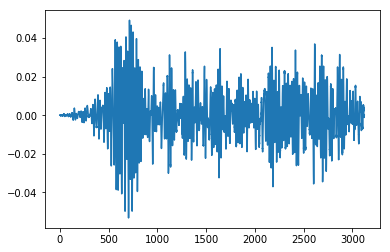

In [90]:
plt.plot(tn, Bx)

In [91]:
from scipy import signal
from matplotlib.colors import LogNorm

In [92]:
f, t, Sxx = signal.spectrogram(Bx[:,0], 1/0.1)
om = 2*np.pi*f

In [93]:
Bx[:,0].shape

(31212,)

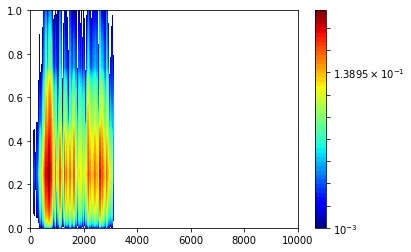

In [94]:
lvls = np.logspace(-3, 0, 50)
plt.contourf(t, om, Sxx/Sxx.max(), 100, norm = LogNorm(), levels = lvls, cmap = 'jet')
plt.ylim((0, 1))
plt.xlim((0, 10000))
plt.colorbar()

In [63]:
t

array([  12.8,   35.2,   57.6,   80. ,  102.4,  124.8,  147.2,  169.6,
        192. ,  214.4,  236.8,  259.2,  281.6,  304. ,  326.4,  348.8,
        371.2,  393.6,  416. ,  438.4,  460.8,  483.2,  505.6,  528. ,
        550.4,  572.8,  595.2,  617.6,  640. ,  662.4,  684.8,  707.2,
        729.6,  752. ,  774.4,  796.8,  819.2,  841.6,  864. ,  886.4,
        908.8,  931.2,  953.6,  976. ,  998.4, 1020.8, 1043.2, 1065.6,
       1088. , 1110.4, 1132.8, 1155.2, 1177.6, 1200. , 1222.4, 1244.8,
       1267.2, 1289.6, 1312. , 1334.4, 1356.8, 1379.2, 1401.6, 1424. ,
       1446.4, 1468.8, 1491.2, 1513.6, 1536. , 1558.4, 1580.8, 1603.2,
       1625.6, 1648. , 1670.4, 1692.8, 1715.2, 1737.6, 1760. , 1782.4,
       1804.8, 1827.2, 1849.6, 1872. , 1894.4, 1916.8, 1939.2, 1961.6,
       1984. , 2006.4, 2028.8, 2051.2, 2073.6, 2096. , 2118.4, 2140.8,
       2163.2, 2185.6, 2208. , 2230.4, 2252.8, 2275.2, 2297.6, 2320. ,
       2342.4, 2364.8, 2387.2, 2409.6, 2432. , 2454.4, 2476.8, 2499.2,
      